In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

import lda_functions
import bert_embed


/home/maror24/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-27 18:25:54.946819: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 18:25:54.946869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 18:25:54.948466: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-27 18:25:54.956412: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is opt

In [2]:
newsgroups_data = fetch_20newsgroups(subset='test')

In [3]:
documents = newsgroups_data.data
print(len(documents))

7532


In [4]:
import random
documents = random.choices(documents, k = 300)

In [5]:
lda_trainer = lda_functions.LDAModelTrainer(documents)
processed_docs = lda_trainer.preprocess()

In [15]:
# Find optimal number of topics with metrics
eval_metrics = lda_trainer.find_optimal_topics(passes = 10, max_topics = 30, start = 5, step = 5)

2024-11-27 17:33:31,026 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2024-11-27 17:33:31,033 : INFO : using serial LDA version on this node
2024-11-27 17:33:31,058 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 18846 documents, updating model once every 2000 documents, evaluating perplexity every 18846 documents, iterating 50x with a convergence threshold of 0.001000
2024-11-27 17:33:31,059 : INFO : PROGRESS: pass 0, at document #2000/18846
2024-11-27 17:33:32,265 : INFO : optimized alpha [0.25881928, 0.23687595, 0.25954032, 0.30191025, 0.25482014]
2024-11-27 17:33:32,275 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-11-27 17:33:32,286 : INFO : topic #0 (0.259): 0.006*"would" + 0.005*"one" + 0.004*"use" + 0.004*"like" + 0.004*"article" + 0.004*"university" + 0.003*"get" + 0.003*"people" + 0.003*"know" + 0.003*"right"
2024-11-27 17:33:32,287 : INFO : topic #1 (0.237): 0.006

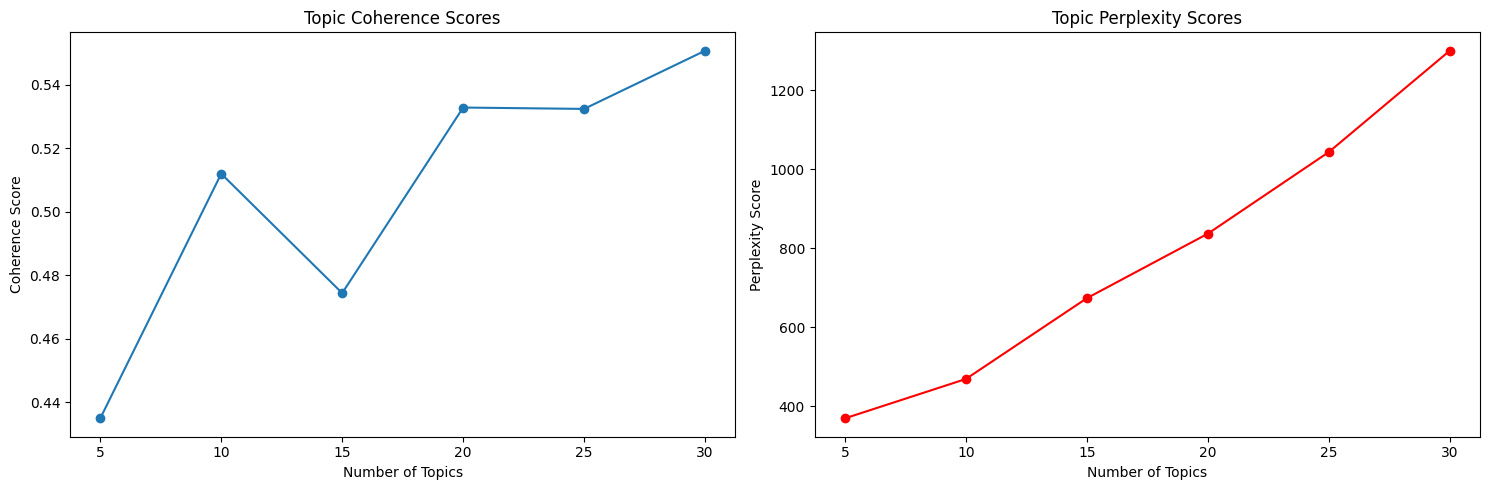

In [16]:
# Plot topic metrics
lda_trainer.plot_topic_metrics()

In [17]:
# Get optimal number of topics
optimal_topics = lda_trainer.get_optimal_topics()
print(f"Optimal number of topics: {optimal_topics}")

Optimal number of topics: 10


In [30]:
# Train final model with optimal topics
final_model = lda_trainer.train_lda_model(num_topics=20, passes = 25)

2024-11-27 18:58:56,363 : INFO : using autotuned alpha, starting with [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
2024-11-27 18:58:56,364 : INFO : using serial LDA version on this node
2024-11-27 18:58:56,371 : INFO : running online (multi-pass) LDA training, 20 topics, 25 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 50x with a convergence threshold of 0.001000
2024-11-27 18:58:56,620 : INFO : -12.770 per-word bound, 6984.7 perplexity estimate based on a held-out corpus of 300 documents with 31192 words
2024-11-27 18:58:56,620 : INFO : PROGRESS: pass 0, at document #300/300
2024-11-27 18:58:56,824 : INFO : optimized alpha [0.047901683, 0.049659308, 0.055063736, 0.050430316, 0.054308765, 0.04918879, 0.054923356, 0.047640797, 0.048351742, 0.047818117, 0.05010621, 0.048111934, 0.05381706, 0.05355019, 0.05429247, 0.0

## Topic Selection

In [6]:
embedder = bert_embed.BertEmbedder()
embeddings = embedder.get_embeddings(documents)

In [31]:
topic_assignment = lda_trainer.predict_topics()
topic_assignment = np.argmax(topic_assignment, axis = 1)

In [33]:
umap_model = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine')
umap_embedding = umap_model.fit_transform(embeddings)

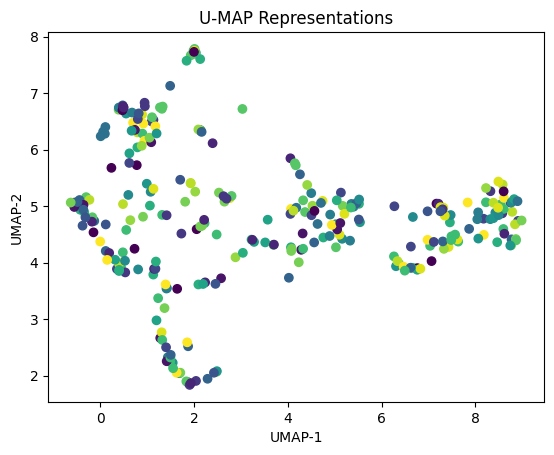

In [34]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:,1], c = topic_assignment)
plt.title('U-MAP Representations')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [9]:
vector_similarities = lda_functions.calculate_similarities(embeddings)

In [23]:
metric_list = []
correlation_list = []
similarities = np.zeros((len(documents), len(documents), 10))
k = 0
for topic_num in range(5, 35, 5):
    print(topic_num)
    model = lda_trainer.train_lda_model(num_topics=topic_num, passes = 25)
    topic_assignment = lda_trainer.predict_topics()
    metrics = lda_functions.evaluate_clustering(np.argmax(topic_assignment, axis =1), embeddings)
    metric_list.append(metrics)
    similarities[:,:, k] = lda_functions.calculate_similarities(topic_assignment)
    correlations= lda_functions.analyze_correlation(vector_similarities, similarities[:,:, k])
    correlation_list.append(correlations)
    k = k + 1

2024-11-27 18:42:42,182 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2024-11-27 18:42:42,183 : INFO : using serial LDA version on this node
2024-11-27 18:42:42,185 : INFO : running online (multi-pass) LDA training, 5 topics, 25 passes over the supplied corpus of 300 documents, updating model once every 300 documents, evaluating perplexity every 300 documents, iterating 50x with a convergence threshold of 0.001000


5


2024-11-27 18:42:42,419 : INFO : -9.142 per-word bound, 564.8 perplexity estimate based on a held-out corpus of 300 documents with 31192 words
2024-11-27 18:42:42,419 : INFO : PROGRESS: pass 0, at document #300/300
2024-11-27 18:42:42,582 : INFO : optimized alpha [0.2354482, 0.2152293, 0.2630795, 0.2442692, 0.24650608]
2024-11-27 18:42:42,584 : INFO : topic #0 (0.235): 0.008*"would" + 0.008*"mhz" + 0.006*"one" + 0.005*"article" + 0.005*"university" + 0.004*"problem" + 0.004*"know" + 0.004*"think" + 0.004*"like" + 0.003*"cpu"
2024-11-27 18:42:42,584 : INFO : topic #1 (0.215): 0.008*"one" + 0.006*"article" + 0.005*"get" + 0.004*"format" + 0.004*"like" + 0.004*"image" + 0.004*"also" + 0.004*"available" + 0.004*"would" + 0.003*"usa"
2024-11-27 18:42:42,585 : INFO : topic #2 (0.263): 0.012*"university" + 0.006*"would" + 0.006*"know" + 0.005*"article" + 0.005*"like" + 0.005*"one" + 0.005*"new" + 0.004*"get" + 0.004*"people" + 0.003*"distribution"
2024-11-27 18:42:42,585 : INFO : topic #3 (0.

10


2024-11-27 18:42:49,311 : INFO : -10.143 per-word bound, 1130.5 perplexity estimate based on a held-out corpus of 300 documents with 31192 words
2024-11-27 18:42:49,311 : INFO : PROGRESS: pass 0, at document #300/300
2024-11-27 18:42:49,478 : INFO : optimized alpha [0.10459219, 0.104393005, 0.11712469, 0.10701794, 0.111742, 0.09982972, 0.11847663, 0.10168157, 0.09287813, 0.09870103]
2024-11-27 18:42:49,481 : INFO : topic #8 (0.093): 0.005*"university" + 0.005*"article" + 0.004*"way" + 0.004*"time" + 0.004*"like" + 0.004*"one" + 0.003*"two" + 0.003*"point" + 0.003*"well" + 0.003*"much"
2024-11-27 18:42:49,482 : INFO : topic #9 (0.099): 0.008*"university" + 0.004*"window" + 0.004*"software" + 0.004*"also" + 0.004*"article" + 0.004*"new" + 0.004*"could" + 0.004*"one" + 0.004*"information" + 0.004*"know"
2024-11-27 18:42:49,482 : INFO : topic #4 (0.112): 0.007*"would" + 0.007*"one" + 0.006*"people" + 0.005*"article" + 0.005*"get" + 0.005*"university" + 0.004*"government" + 0.004*"time" + 0

15


2024-11-27 18:42:55,841 : INFO : -11.369 per-word bound, 2644.2 perplexity estimate based on a held-out corpus of 300 documents with 31192 words
2024-11-27 18:42:55,841 : INFO : PROGRESS: pass 0, at document #300/300
2024-11-27 18:42:56,072 : INFO : optimized alpha [0.06760078, 0.063309565, 0.07715045, 0.07082061, 0.07198136, 0.064989805, 0.07488592, 0.0643318, 0.062146634, 0.06245414, 0.067805655, 0.065211564, 0.07288871, 0.072113514, 0.0713514]
2024-11-27 18:42:56,078 : INFO : topic #8 (0.062): 0.006*"university" + 0.005*"article" + 0.005*"102" + 0.005*"like" + 0.004*"way" + 0.004*"get" + 0.004*"two" + 0.004*"use" + 0.004*"window" + 0.004*"well"
2024-11-27 18:42:56,084 : INFO : topic #9 (0.062): 0.008*"university" + 0.004*"file" + 0.004*"tom" + 0.004*"window" + 0.004*"image" + 0.004*"article" + 0.004*"102" + 0.004*"information" + 0.004*"disease" + 0.004*"program"
2024-11-27 18:42:56,084 : INFO : topic #12 (0.073): 0.010*"would" + 0.009*"one" + 0.006*"think" + 0.005*"thing" + 0.005*"a

20


2024-11-27 18:43:03,824 : INFO : -12.770 per-word bound, 6984.7 perplexity estimate based on a held-out corpus of 300 documents with 31192 words
2024-11-27 18:43:03,825 : INFO : PROGRESS: pass 0, at document #300/300
2024-11-27 18:43:04,037 : INFO : optimized alpha [0.047901683, 0.049659308, 0.055063736, 0.050430316, 0.054308765, 0.04918879, 0.054923356, 0.047640797, 0.048351742, 0.047818117, 0.05010621, 0.048111934, 0.05381706, 0.05355019, 0.05429247, 0.055171993, 0.046423484, 0.05119435, 0.051220354, 0.04982277]
2024-11-27 18:43:04,045 : INFO : topic #16 (0.046): 0.008*"people" + 0.007*"would" + 0.006*"like" + 0.006*"car" + 0.006*"article" + 0.005*"one" + 0.004*"problem" + 0.004*"usa" + 0.004*"university" + 0.003*"state"
2024-11-27 18:43:04,045 : INFO : topic #7 (0.048): 0.007*"university" + 0.006*"medical" + 0.005*"page" + 0.005*"post" + 0.005*"patient" + 0.005*"information" + 0.004*"new" + 0.004*"press" + 0.004*"april" + 0.004*"said"
2024-11-27 18:43:04,046 : INFO : topic #6 (0.055

25


2024-11-27 18:43:11,783 : INFO : -14.302 per-word bound, 20200.0 perplexity estimate based on a held-out corpus of 300 documents with 31192 words
2024-11-27 18:43:11,783 : INFO : PROGRESS: pass 0, at document #300/300
2024-11-27 18:43:12,003 : INFO : optimized alpha [0.039902538, 0.037435327, 0.043839734, 0.04096756, 0.041624658, 0.038489245, 0.044168785, 0.038748153, 0.038558934, 0.03825587, 0.041067816, 0.039618243, 0.042015325, 0.041889098, 0.04176905, 0.04392731, 0.037897293, 0.040357742, 0.04113584, 0.04112636, 0.03807267, 0.038422782, 0.039127316, 0.042145528, 0.03924973]
2024-11-27 18:43:12,012 : INFO : topic #1 (0.037): 0.008*"one" + 0.007*"usa" + 0.007*"article" + 0.006*"get" + 0.005*"well" + 0.005*"like" + 0.004*"pat" + 0.004*"format" + 0.004*"morality" + 0.004*"image"
2024-11-27 18:43:12,013 : INFO : topic #16 (0.038): 0.008*"would" + 0.007*"like" + 0.006*"usa" + 0.006*"people" + 0.005*"article" + 0.005*"one" + 0.004*"eric" + 0.004*"game" + 0.004*"courier" + 0.004*"oplinger"

30


2024-11-27 18:43:19,954 : INFO : -15.943 per-word bound, 63006.5 perplexity estimate based on a held-out corpus of 300 documents with 31192 words
2024-11-27 18:43:19,954 : INFO : PROGRESS: pass 0, at document #300/300
2024-11-27 18:43:20,181 : INFO : optimized alpha [0.033453066, 0.03176463, 0.03681893, 0.03354448, 0.034567058, 0.03198188, 0.036021214, 0.03246888, 0.033126026, 0.031563785, 0.0332961, 0.032872245, 0.03576097, 0.035666976, 0.035134315, 0.034873474, 0.031471137, 0.033395745, 0.035113618, 0.033472452, 0.03196515, 0.033619896, 0.03342732, 0.034056757, 0.033299234, 0.03248211, 0.031782668, 0.032605577, 0.032240916, 0.035687253]
2024-11-27 18:43:20,191 : INFO : topic #16 (0.031): 0.015*"usa" + 0.008*"eric" + 0.008*"canada" + 0.007*"would" + 0.007*"game" + 0.007*"penalty" + 0.006*"1st" + 0.006*"one" + 0.006*"3rd" + 0.006*"2nd"
2024-11-27 18:43:20,192 : INFO : topic #9 (0.032): 0.009*"university" + 0.006*"help" + 0.006*"new" + 0.005*"disease" + 0.005*"could" + 0.005*"file" + 0.

In [26]:
results = pd.DataFrame(metric_list)
results.index = range(5, 35,5)

results

,silhouette_score,calinski_harabasz,davies_bouldin
5,-0.032360,1.302993,11.563612
10,-0.050376,1.379542,8.656239
15,-0.089950,1.362305,7.326789
20,-0.093213,1.193156,6.706879
25,-0.131589,1.271004,6.005318
30,-0.151077,1.000131,5.668116


In [25]:
resultscorr = pd.DataFrame(correlation_list)
resultscorr.index = range(5, 35,5)
resultscorr

,pearson_correlation,pearson_p_value,spearman_correlation,spearman_p_value,r_squared
5,0.029543,7.675810e-19,0.025947,6.961551e-15,0.000873
10,0.043001,4.158527e-38,0.032552,1.545410e-22,0.001849
15,0.039820,6.438255e-33,0.046372,4.867169e-44,0.001586
20,0.042071,1.501834e-36,0.040408,7.594857e-34,0.001770
25,0.039627,1.295252e-32,0.026831,8.241072e-16,0.001570
30,0.040957,9.989228e-35,0.029470,9.346898e-19,0.001677


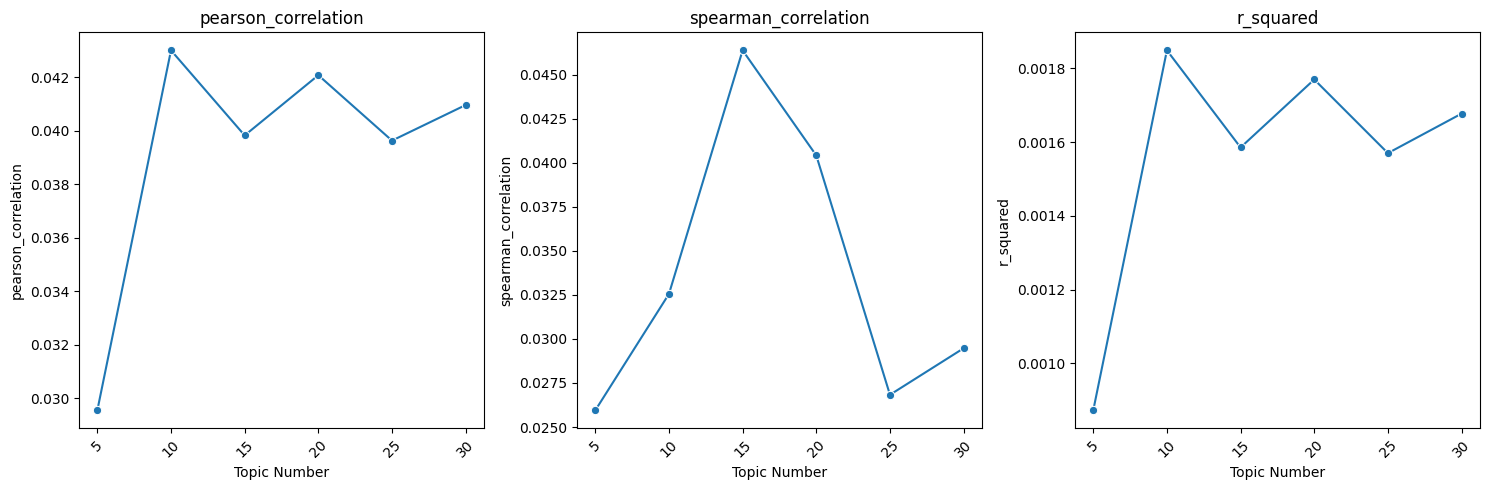

In [27]:
# Plot performance metrics
plt.figure(figsize=(15, 5))
for i, metric in enumerate(['pearson_correlation', 'spearman_correlation', 'r_squared'], 1):
    plt.subplot(1, 3, i)
    sns.lineplot(data=resultscorr, x=resultscorr.index, y=metric, marker='o')
    plt.title(f'{metric}')
    plt.xlabel('Topic Number')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

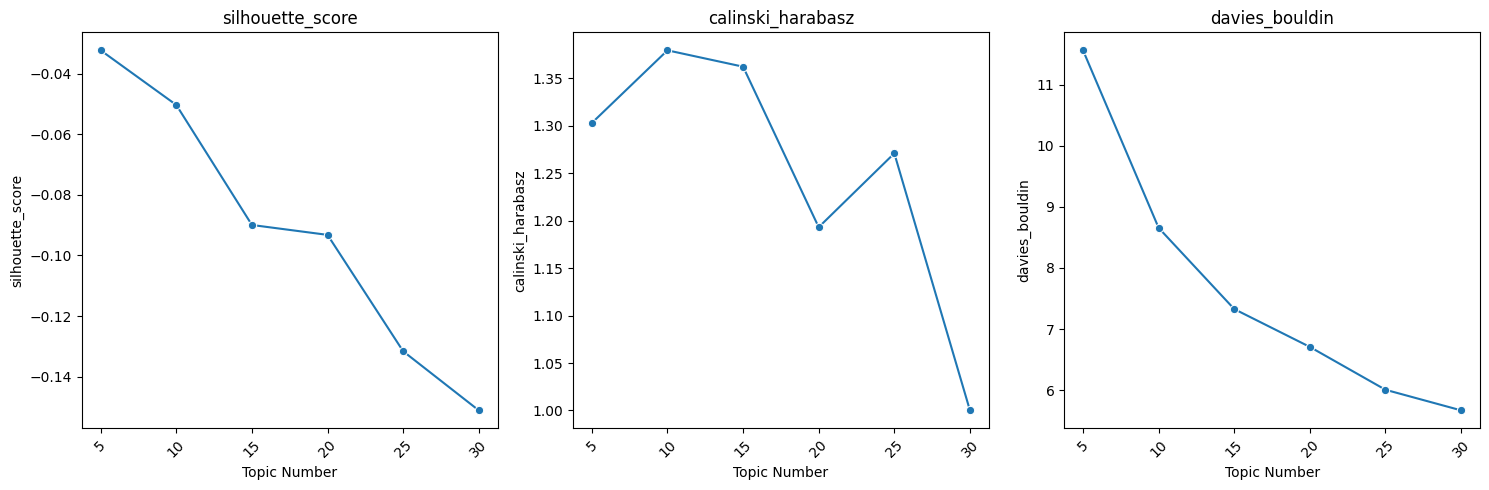

In [28]:
# Plot performance metrics
plt.figure(figsize=(15, 5))
for i, metric in enumerate(['silhouette_score', 'calinski_harabasz', 'davies_bouldin'], 1):
    plt.subplot(1, 3, i)
    sns.lineplot(data=results, x=results.index, y=metric, marker='o')
    plt.title(f'{metric}')
    plt.xlabel('Topic Number')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
